# <center>Gişe Verilerine Göre Hasılat Tahmini<br>Veri Ön İşleme Aşaması</center>

# İçindekiler
* [Kütüphaneler](#Kütüphaneler)
* [Veri Seti](#Veri-Seti)
    * [İlk Gözlemler](#İlk-Gözlemler)
* [Verilerin İşlenmesi](#Verilerin-İşlenmesi)
    * [URL Sütununun Kaldırılması ve Eksik Verilerin Doldurulması](#URL-Sütununun-Kaldırılması-ve-Eksik-Verilerin-Doldurulması)
    * [Zaman Serisi için İndeks Seçimi](#Zaman-Serisi-için-İndeks-Seçimi)
    * [Zaman Değişkenlerinin Eklenmesi](#Zaman-Değişkenlerinin-Eklenmesi)
* [Zaman Serisinin Yeniden Örneklenmesi](#Zaman-Serisinin-Yeniden-Örneklenmesi)
    * [Yıllık, Çeyreklik, Aylık ve Haftalık Ortalama Hasılat Grafiği](#Yıllık,-Çeyreklik,-Aylık-ve-Haftalık-Ortalama-Hasılat-Grafiği)
* [Zaman Serisinin Trend ve Mevsimsellik Bileşenlerine Ayrıştırılması](#Zaman-Serisinin-Trend-ve-Mevsimsellik-Bileşenlerine-Ayrıştırılması)
    * [Aylık ve Çeyreklik Mevsimsellik Grafikleri](#Aylık-ve-Çeyreklik-Mevsimsellik-Grafikleri)
    * [Zaman Serisinin Trend ve Mevsimsellik Bileşenlerine Ayrıştırılması](#Zaman-Serisinin-Trend-ve-Mevsimsellik-Bileşenlerine-Ayrıştırılması)
* [Otokorelasyon](#Otokorelasyon)
* [Özellik Mühendisliği](#Özellik-Mühendisliği)
* [Keşifsel Veri Analizi](#Keşifsel-Veri-Analizi)
    * [Aykırı Değerlerin Tespiti için Kutu Grafiği](#Aykırı-Değerlerin-Tespiti-için-Kutu-Grafiği)
    * [Günlük Toplam Hasılatın Haftanın Günlerine ve Aylara Göre Dağılım Grafiği](#Günlük-Toplam-Hasılatın-Haftanın-Günlerine-ve-Aylara-Göre-Dağılım-Grafiği)
    * [Yıllara Göre Günün İlk Sırasına En Çok Hasılatla Yerleşen Filmler](#Yıllara-Göre-Günün-İlk-Sırasına-En-Çok-Hasılatla-Yerleşen-Filmler)
* [Hasılat Verilerinin Normalizasyonu](#Hasılat-Verilerinin-Normalizasyonu)
* [Yeni Veri Setlerinin Kaydedilmesi](#Yeni-Veri-Setlerinin-Kaydedilmesi)

## <center>Kütüphaneler</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf
from sklearn.preprocessing import MinMaxScaler

##  <center>Veri Seti</center>

In [2]:
df = pd.read_csv('../data/raw/box_office.csv')

### İlk Gözlemler

Veri seti, 5781 satır ve 8 sütundan oluşmaktadır:
- **url:** O günün bireysel sayfasının URL'sini içerir.
- **date:** O güne ait tarihi içerir.
- **day_of_year:** Yılın kaçıncı günü olduğunu belirtir.
- **releases:** O gün vizyonda olan film sayısını gösterir.
- **top_1_gross:** O gün hasılat bakımından birinci sahip olan filmin günlük hasılatını belirtir.
- **top_1_release:** O gün hasılat bakımından birinci olan filmin adını içerir.
- **top_10_gross:** O gün hasılat bakımından ilk on film arasına giren filmlerin günlük toplam hasılatını gösterir.
- **total_gross:** O gün vizyonda olan tüm filmlerin günlük toplam hasılatını belirtir.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5781 entries, 0 to 5780
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            5781 non-null   object 
 1   date           5781 non-null   object 
 2   day_of_year    5781 non-null   int64  
 3   releases       5781 non-null   int64  
 4   top_1_gross    5781 non-null   int64  
 5   top_1_release  5781 non-null   object 
 6   top_10_gross   5781 non-null   int64  
 7   total_gross    5773 non-null   float64
dtypes: float64(1), int64(4), object(3)
memory usage: 361.4+ KB


#### İlk 5 Satırın Listelenmesi

In [4]:
df.head()

,url,date,day_of_year,releases,top_1_gross,top_1_release,top_10_gross,total_gross
0,https://www.boxofficemojo.com/date/2024-11-04/...,2024-11-04,309,26,2131745,Venom: The Last Dance,5482795,5780113.0
1,https://www.boxofficemojo.com/date/2024-11-03/...,2024-11-03,308,42,7675943,Venom: The Last Dance,18050564,20232553.0
2,https://www.boxofficemojo.com/date/2024-11-02/...,2024-11-02,307,42,11617451,Venom: The Last Dance,27389412,30468728.0
3,https://www.boxofficemojo.com/date/2024-11-01/...,2024-11-01,306,42,6609372,Venom: The Last Dance,17850181,20156521.0
4,https://www.boxofficemojo.com/date/2024-10-31/...,2024-10-31,305,43,2802359,Venom: The Last Dance,8114488,8533888.0


#### Eksik Verilerin Kontrol Edilmesi

In [5]:
df.isnull().sum()

url              0
date             0
day_of_year      0
releases         0
top_1_gross      0
top_1_release    0
top_10_gross     0
total_gross      8
dtype: int64

## <center> Verilerin İşlenmesi</center>

### URL Sütununun Kaldırılması ve Eksik Verilerin Doldurulması

In [6]:
processed_df = df.drop('url', axis=1)
processed_df['total_gross'] = processed_df['total_gross'].interpolate(method='linear')
processed_df['total_gross'] = processed_df['total_gross'].astype(int)

### Zaman Serisi için İndeks Seçimi

In [7]:
processed_df['date'] = pd.to_datetime(processed_df['date'], format='%Y-%m-%d')
processed_df.set_index('date', inplace=True)
processed_df = processed_df.sort_index()

### Zaman Değişkenlerinin Eklenmesi

In [8]:
processed_df['year'] = processed_df.index.year
processed_df['month'] = processed_df.index.month
processed_df['day_of_month'] = processed_df.index.day
processed_df['weekday'] = processed_df.index.weekday
processed_df['is_weekend'] = processed_df.index.weekday > 4
processed_df['quarter'] = ((processed_df.index.month - 1) // 3) + 1
processed_df.head()

,day_of_year,releases,top_1_gross,top_1_release,top_10_gross,total_gross,year,month,day_of_month,weekday,is_weekend,quarter
date,,,,,,,,,,,,
2009-01-01,1,51,9956212,Marley & Me,50130384,60629724,2009,1,1,3,False,1
2009-01-02,2,47,9637373,Marley & Me,48408846,59015468,2009,1,2,4,False,1
2009-01-03,3,47,9177480,Marley & Me,47171312,58159350,2009,1,3,5,True,1
2009-01-04,4,47,5448910,Marley & Me,27734486,34601286,2009,1,4,6,True,1
2009-01-05,5,46,1571618,Marley & Me,8544303,10845291,2009,1,5,0,False,1


## <center>Zaman Serisinin Yeniden Örneklenmesi</center>

In [9]:
weekly_resample = processed_df['total_gross'].resample('W').mean()
monthly_resample = processed_df['total_gross'].resample('ME').mean()
quarterly_resample = processed_df['total_gross'].resample('QE').mean()
yearly_resample = processed_df['total_gross'].resample('YE').mean()

numeric_df = processed_df.select_dtypes(include='number')
columns_to_drop = ['year', 'month', 'day_of_month', 'quarter', 'weekday', 'day_of_year']
numeric_df = numeric_df.drop(columns=columns_to_drop)

df_weekly = numeric_df.resample('W').mean()
df_monthly = numeric_df.resample('ME').mean()
df_quarterly = numeric_df.resample('QE').mean()
df_yearly = numeric_df.resample('YE').mean()

df_weekly.to_csv('../data/resampled/weekly_box_office.csv')
df_monthly.to_csv('../data/resampled/monthly_box_office.csv')
df_quarterly.to_csv('../data/resampled/quarterly_box_office.csv')
df_yearly.to_csv('../data/resampled/yearly_box_office.csv')

#### Yıllık, Çeyreklik, Aylık ve Haftalık Ortalama Hasılat Grafiği

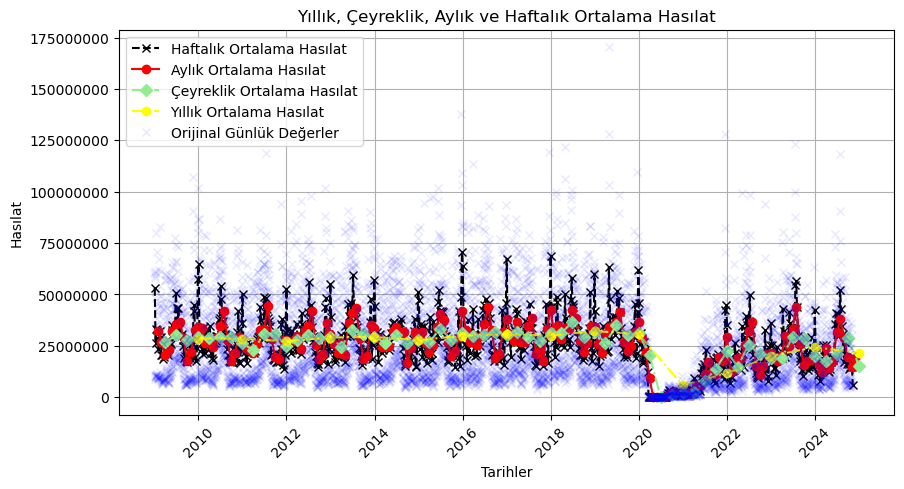

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(weekly_resample.index, weekly_resample.values, label='Haftalık Ortalama Hasılat', linestyle='--', marker='x', color='black')
plt.plot(monthly_resample.index, monthly_resample.values, label='Aylık Ortalama Hasılat', marker='o', color='red')
plt.plot(quarterly_resample.index, quarterly_resample.values, label='Çeyreklik Ortalama Hasılat', linestyle='-.', marker='D', color='lightgreen')
plt.plot(yearly_resample.index, yearly_resample.values, label='Yıllık Ortalama Hasılat', linestyle='-.', marker='o', color='yellow')
plt.plot(processed_df.index, processed_df['total_gross'], label='Orijinal Günlük Değerler', linestyle='', marker='x', color='blue', alpha=0.09)
plt.title('Yıllık, Çeyreklik, Aylık ve Haftalık Ortalama Hasılat')
plt.xlabel('Tarihler')
plt.ylabel('Hasılat')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

## <center> Zaman Serisinin Trend ve Mevsimsellik Bileşenlerine Ayrıştırılması </center>

**Trend:** Verideki uzun vadede gözlemlenen genel hareketi ifade eder.

**Mevsimsellik:** Verinin belirli bir periyodik döngüde değişen ve bu değişikliklerin önceden tahmin edilebilir olduğu durumu ifade eder.

### Aylık ve Çeyreklik Mevsimsellik Grafikleri

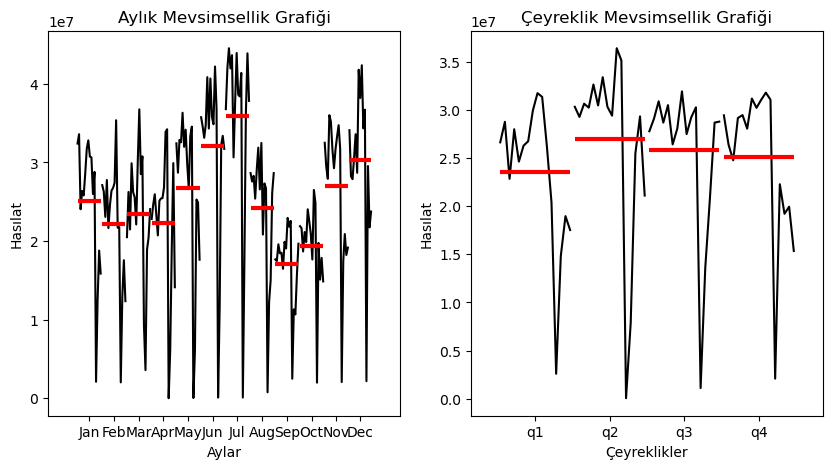

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
month_plot(monthly_resample, ax=axes[0])
axes[0].set_xlabel('Aylar')
axes[0].set_ylabel('Hasılat')
axes[0].set_title('Aylık Mevsimsellik Grafiği')
quarter_plot(quarterly_resample, ax=axes[1])
axes[1].set_xlabel('Çeyreklikler')
axes[1].set_ylabel('Hasılat')
axes[1].set_title('Çeyreklik Mevsimsellik Grafiği')
plt.show()

### Verinin Trend ve Mevsimsellik Bileşenlerine Ayrıştırılması

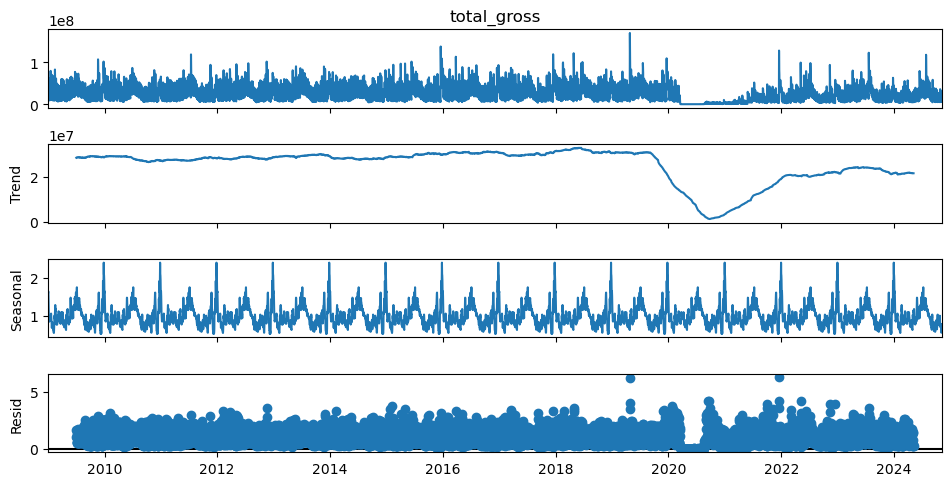

In [12]:
decomposition = seasonal_decompose(processed_df['total_gross'], model='multiplicative', period=365)
fig = decomposition.plot()
fig.set_size_inches(10, 5)
plt.show()

### Pandemi Öncesi, Pandemi Dönemi ve Pandemi Sonrası Verilerin Ayrı Ayrı İncelenmesi

In [13]:
pandemic_start = pd.to_datetime('2020-03-12')
pandemic_end = pd.to_datetime('2021-06-14')
post_pandemic_start = pd.to_datetime('2021-06-15')

# Pandemi öncesi
pre_pandemic_df = processed_df[processed_df.index < pandemic_start]

# Pandemi dönemi
pandemic_df = processed_df[(processed_df.index >= pandemic_start) & (processed_df.index <= pandemic_end)]

# Pandemi sonrası
post_pandemic_df = processed_df[processed_df.index >= post_pandemic_start]

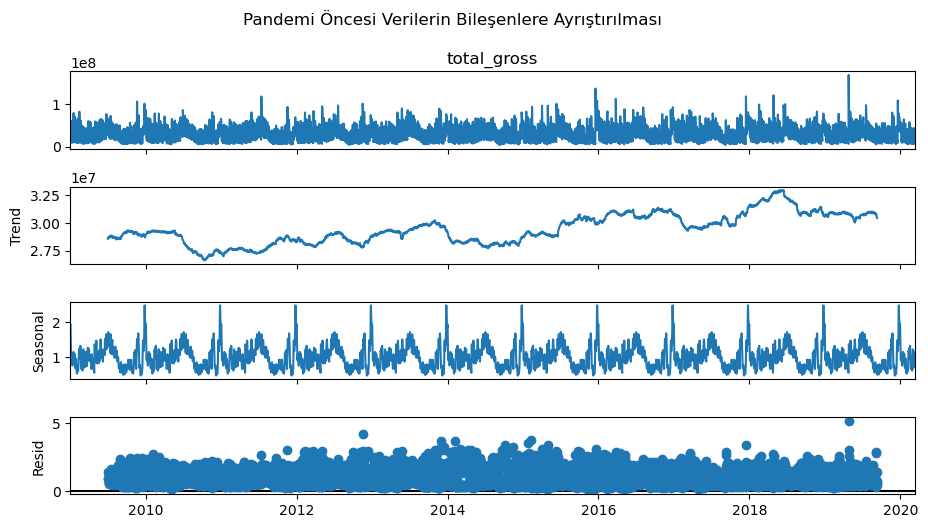

In [14]:
decomposition = seasonal_decompose(pre_pandemic_df['total_gross'], model='multiplicative', period=365)
fig = decomposition.plot()
fig.set_size_inches(10, 5)
fig.suptitle('Pandemi Öncesi Verilerin Bileşenlere Ayrıştırılması', y=1.05)
plt.show()

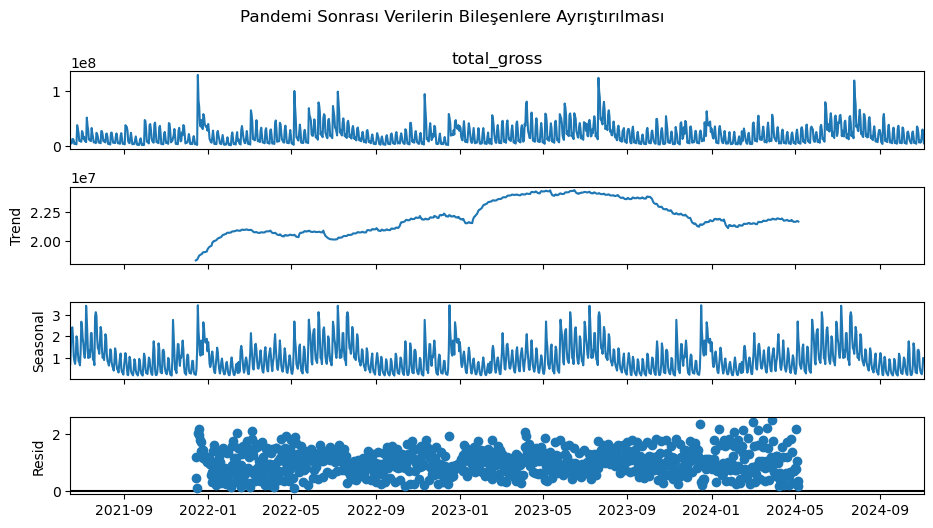

In [15]:
decomposition = seasonal_decompose(post_pandemic_df['total_gross'], model='multiplicative', period=365)
fig = decomposition.plot()
fig.set_size_inches(10, 5)
fig.suptitle('Pandemi Sonrası Verilerin Bileşenlere Ayrıştırılması', y=1.05)
plt.show()

## <center >Otokorelasyon </center>

Otokorelasyon, zaman serilerinde serinin gecikmeli değerleriyle şu anki değerleri arasındaki ilişkiyi ölçer. Değerlerin kendi kendisiyle olan korelasyonunu gösterir.

Otokorelasyon katsayısı 1 ile -1 arasında değişiklik gösterir:

* **1'e yakın değerler:** Pozitif otokorelasyon anlamına gelir. Önceki değerlerle benzer yönde bir değişim eğilimi gösterir.
* **0’a yakın değerler:** Otokorelasyonun zayıf olduğunu gösterir. Geçmiş verilerin mevcut veriler üzerindeki etkisi yok sayılır.
* **-1’e yakın değerler:** Negatif otokorelasyon anlamına gelir. Önceki değerlerin tersine hareket eder.

Otokorelasyonu gözlemek için statsmodels ACF kütüphanesiyle 30 gecikmeye kadar otokorelasyon grafiğini çiziyoruz:

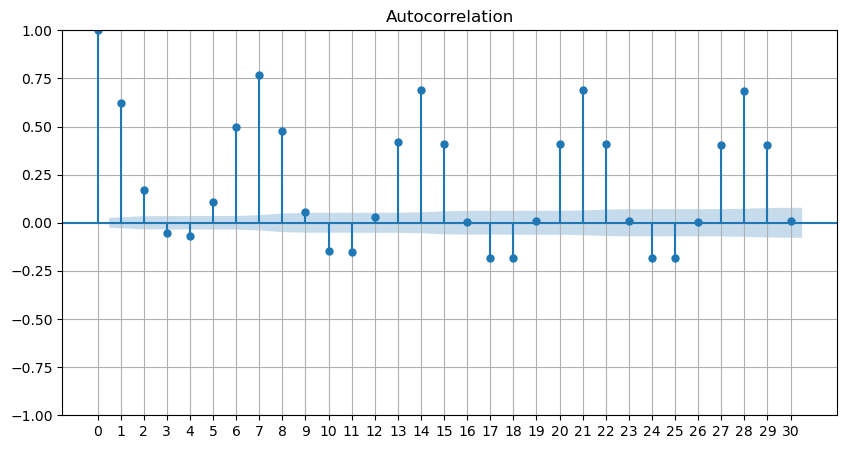

In [16]:
fig, ax = plt.subplots(figsize = (10, 5))
plot_acf(processed_df['total_gross'], lags = 30, ax = ax)
ax.set_xticks(range(0, 31, 1))
plt.grid(True)
plt.show()

Yukarıdaki otokorelasyon grafiğine bakıldığı zaman otokorelasyon değerlerinin 7 günlük aralıklarla yükseldiği gözlemleniyor. Buradan yola çıkılarak günlük toplam hasılat değerlerinin **haftalık** olarak mevsimsellik gösterdiği şeklinde bir yorum yapabilir.

## <center>Özellik Mühendisliği</center>

**Özellik:** Verideki gözlemler hakkında bilgi veren her bir değişken veya özniteliktir.

**Özellik Mühendisliği:** Ham veriyi modellemede kullanılabilecek özelliklere dönüştürmek için seçme, manipüle etme ve dönüştürme sürecidir.

Otokorelasyon grafiğinden elde ettiğimiz sonuç bağlamında haftalık döngülerin etkisinin modelleme aşamasında faydalı olması adına veri setine 7 günlük gecikmeli toplam hasılat değerlerini içeren bir sütun ekliyoruz.

In [17]:
processed_df['total_gross_lag7'] = processed_df['total_gross'].shift(7).bfill()

Toplam hasılat değerleri günlük olarak değişkenlik gösterdiği ve dalgalanmalı olduğundan, kısa vadeli dalgalanmaları yumuşatmak ve genel eğilimi belirlemek için 7 ve 30 günlük **hareketli ortalamaları** içeren sütunları ekliyoruz.

Günlük getirileri içeren sütunu ekliyoruz.
  
* **Günlük Getiri (Daily Returns):** Her günün bir önceki güne göre yüzde değişim oranını gösterir. Genelde finansal zaman serilerinin analizinde kullanılsa da film hasılatları için o gün vizyonda olan filmlerin sayısı, günlük toplam hasılat, o gün birinci olmuş filmin hasılatı ve o günün ilk on filminin toplam hasılatı gibi verilerle birlikte değerlendirildiğinde anlamlı hale gelebilir.

Holidays kütüphanesinden yararlanarak ilgili günün tatil olup olmadığını belirten bir sütun ekliyoruz.

In [18]:
processed_df['7_day_rolling_total'] = processed_df['total_gross'].rolling(window = 7).mean()
processed_df['30_day_rolling_total'] = processed_df['total_gross'].rolling(window = 30).mean()
# Günlük getiri:
processed_df['daily_returns'] = processed_df['total_gross'].pct_change(fill_method=None) * 100
# Tatiller:
holidays = holidays.US()
processed_df['is_holiday'] = processed_df.index.to_series().apply(lambda x: x in holidays)

# 7 ve 30 günlük hareketli ortalamalardaki sütunlar sırasıyla ilk 7 ve ilk 30 günün değerlerini hesaplamaz.
# Günlük getiri sütunu ilk günün, haftalık getiri sütunu ilk 7 günün değerini hesaplamaz.
# Bu yüzden backward fill kullanıyoruz:

processed_df['7_day_rolling_total'] = processed_df['7_day_rolling_total'].bfill()
processed_df['30_day_rolling_total'] = processed_df['30_day_rolling_total'].bfill()
processed_df['daily_returns'] = processed_df['daily_returns'].bfill()

Döngüsel verilere sinüs ve kosinüs dönüşümü uygulayıp ve bool değişkenlerini int olarak düzenliyoruz:

In [19]:
# Haftanın günleri
processed_df['weekday_sin'] = np.sin(2 * np.pi * processed_df['weekday'] / 7)
processed_df['weekday_cos'] = np.cos(2 * np.pi * processed_df['weekday'] / 7)
# Aylar
processed_df['month_sin'] = np.sin(2 * np.pi * processed_df['month'] / 12)
processed_df['month_cos'] = np.cos(2 * np.pi * processed_df['month'] / 12)
# Çeyreklikler
processed_df['quarter_sin'] = np.sin(2 * np.pi * processed_df['quarter'] / 4)
processed_df['quarter_cos'] = np.cos(2 * np.pi * processed_df['quarter'] / 4)
# Yılın günleri
processed_df['day_of_year_sin'] = np.sin(2 * np.pi * processed_df['day_of_year'] / 365.25)
processed_df['day_of_year_cos'] = np.cos(2 * np.pi * processed_df['day_of_year'] / 365.25)
# Bool değişkenler
processed_df['is_holiday'] = processed_df['is_holiday'].astype(int)
processed_df['is_weekend'] = processed_df['is_weekend'].astype(int)

## <center>Keşifsel Veri Analizi</center>

### Aykırı Değerlerin (Outliers) Tespiti için Kutu Grafiği

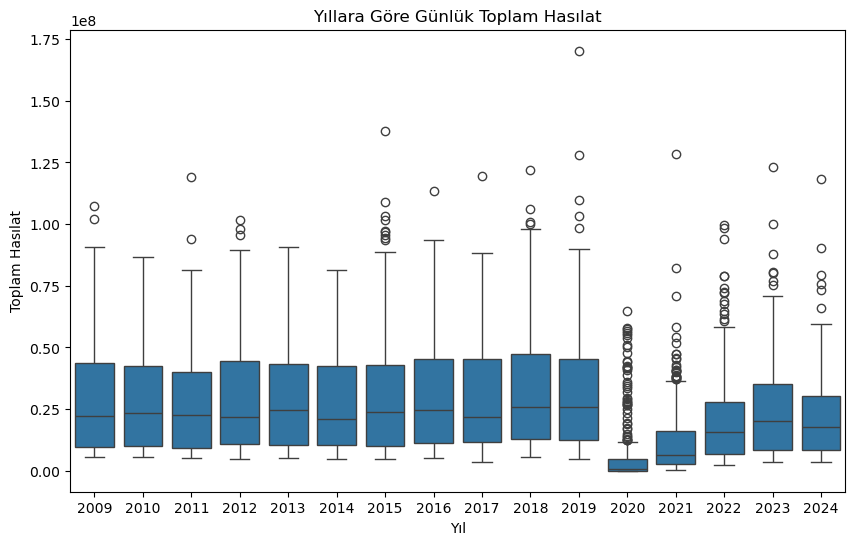

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='year', y='total_gross', data=processed_df)
plt.title('Yıllara Göre Günlük Toplam Hasılat')
plt.xlabel('Yıl')
plt.ylabel('Toplam Hasılat')
plt.show()

İlgili günün pandemi dönemi olup olmadığını belirten bir sütun ekliyoruz:

In [21]:
processed_df['is_pandemic'] = ((processed_df.index >= pandemic_start) & (processed_df.index <= pandemic_end)).astype(int)

### Günlük Toplam Hasılatın Haftanın Günlerine ve Aylara Göre Dağılım Grafiği

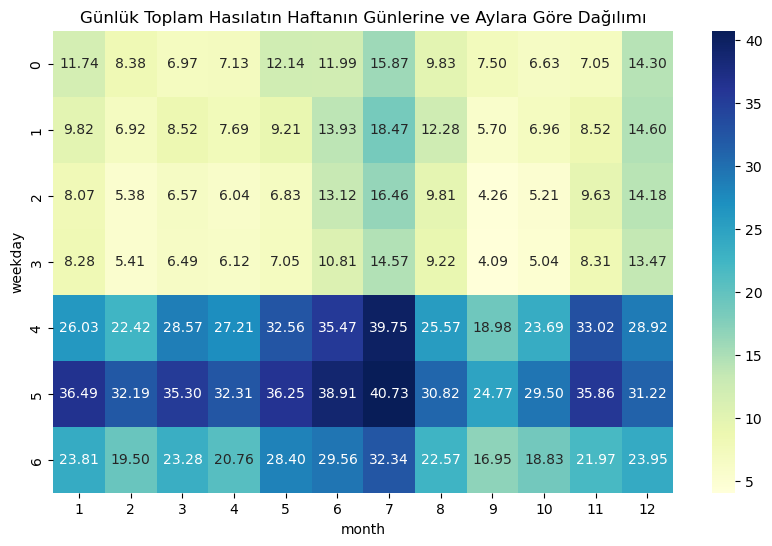

In [22]:
plt.figure(figsize=(10, 6))
pivot_data = processed_df.pivot_table(index='weekday', columns='month', values='total_gross', aggfunc='sum')
pivot_data = pivot_data / 100_000_000
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt='.2f')
plt.title('Günlük Toplam Hasılatın Haftanın Günlerine ve Aylara Göre Dağılımı')
plt.show()

### 2019 ve 2023 Günlük Toplam Hasılat Grafikleri

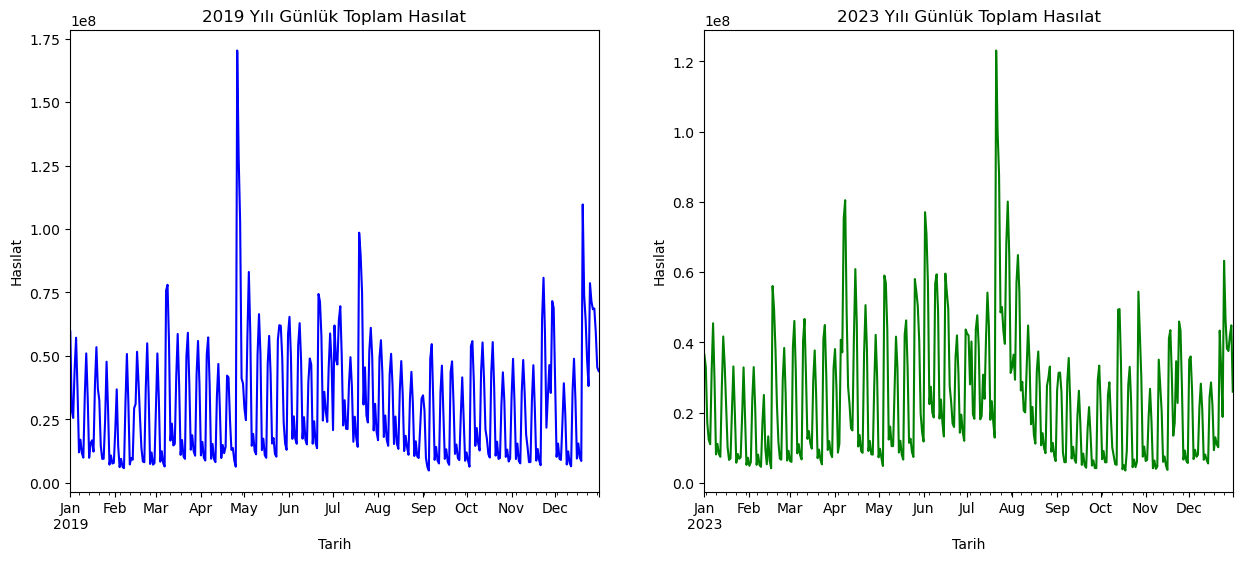

In [23]:
df_2019 = processed_df[processed_df['year'] == 2019]
df_2023 = processed_df[processed_df['year'] == 2023]
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# 2019
df_2019.groupby('date')['total_gross'].sum().plot(ax=axes[0], color='b')
axes[0].set_title('2019 Yılı Günlük Toplam Hasılat')
axes[0].set_xlabel('Tarih')
axes[0].set_ylabel('Hasılat')
# 2023
df_2023.groupby('date')['total_gross'].sum().plot(ax=axes[1], color='g')
axes[1].set_title('2023 Yılı Günlük Toplam Hasılat')
axes[1].set_xlabel('Tarih')
axes[1].set_ylabel('Hasılat')
plt.show()

### En Yüksek ve En Düşük Hasılatın Elde Edildiği Günler

In [24]:
max_revenue_day_idx = processed_df['total_gross'].idxmax() 
max_revenue = processed_df.loc[max_revenue_day_idx, 'total_gross']
max_revenue_day_date = max_revenue_day_idx.date()
print(f'En yüksek hasılat: ${max_revenue:,.2f}, Gün: {max_revenue_day_date}')

En yüksek hasılat: $170,315,497.00, Gün: 2019-04-26


In [25]:
processed_df.loc['2019-04-26']

day_of_year                           116
releases                               62
top_1_gross                     157461641
top_1_release           Avengers: Endgame
top_10_gross                    169024740
total_gross                     170315497
year                                 2019
month                                   4
day_of_month                           26
weekday                                 4
is_weekend                              0
quarter                                 2
total_gross_lag7               42209153.0
7_day_rolling_total       39760410.857143
30_day_rolling_total      28770842.166667
daily_returns                  2598.20235
is_holiday                              0
weekday_sin                     -0.433884
weekday_cos                     -0.900969
month_sin                        0.866025
month_cos                            -0.5
quarter_sin                           0.0
quarter_cos                          -1.0
day_of_year_sin                  0

In [26]:
min_revenue_day_idx = processed_df['total_gross'].idxmin() 
min_revenue = processed_df.loc[min_revenue_day_idx, 'total_gross']
min_revenue_day_date = min_revenue_day_idx.date()
print(f'En düşük hasılat: ${min_revenue:,.2f}, Gün: {min_revenue_day_date}')

En düşük hasılat: $4.00, Gün: 2020-03-24


In [27]:
processed_df.loc['2020-03-24']

day_of_year                          84
releases                              1
top_1_gross                           4
top_1_release             The Gentlemen
top_10_gross                          4
total_gross                           4
year                               2020
month                                 3
day_of_month                         24
weekday                               1
is_weekend                            0
quarter                               1
total_gross_lag7              1393371.0
7_day_rolling_total        59157.142857
30_day_rolling_total    11833260.766667
daily_returns                -66.666667
is_holiday                            0
weekday_sin                    0.781831
weekday_cos                     0.62349
month_sin                           1.0
month_cos                           0.0
quarter_sin                         1.0
quarter_cos                         0.0
day_of_year_sin                0.992099
day_of_year_cos                0.125461


### Yıllara Göre Günün İlk Sırasına En Çok Hasılatla Yerleşen Filmler

In [28]:
result = processed_df.loc[processed_df.groupby(['year'])['top_1_gross'].idxmax()]
result['top_1_gross_format'] = result['top_1_gross'].map('${:,.2f}'.format)
result[['year', 'top_1_release', 'top_1_gross_format']]

,year,top_1_release,top_1_gross_format
date,,,
2009-11-20,2009,The Twilight Saga: New Moon,"$72,703,754.00"
2010-06-30,2010,The Twilight Saga: Eclipse,"$68,533,840.00"
2011-07-15,2011,Harry Potter and the Deathly Hallows: Part 2,"$91,071,119.00"
2012-05-04,2012,The Avengers,"$80,813,985.00"
2013-11-22,2013,The Hunger Games: Catching Fire,"$70,950,136.00"
2014-11-21,2014,The Hunger Games: Mockingjay - Part 1,"$55,139,942.00"
2015-12-18,2015,Star Wars: Episode VII - The Force Awakens,"$119,119,282.00"
2016-03-25,2016,Batman v Superman: Dawn of Justice,"$81,558,505.00"
2017-12-15,2017,Star Wars: Episode VIII - The Last Jedi,"$104,684,491.00"


#### Yıllara Göre Günün İlk Sırasına En Çok Hasılatla Yerleşen Filmlerin Grafiği

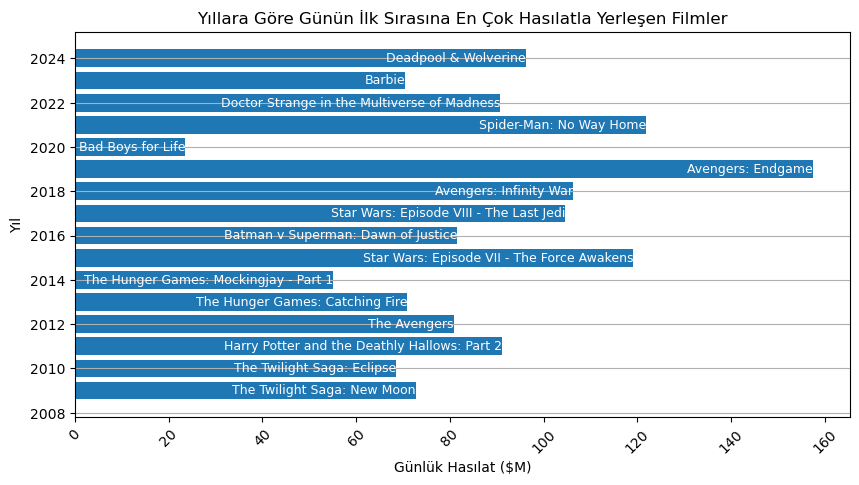

In [29]:
result['top_1_gross'] = result['top_1_gross'] / 1_000_000
plt.figure(figsize=(10,5))
bars = plt.barh(result['year'], result['top_1_gross'])

for bar, film in zip(bars, result['top_1_release']):
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height()/2, film, va='center', ha='right', fontsize=9, color='white')

plt.title('Yıllara Göre Günün İlk Sırasına En Çok Hasılatla Yerleşen Filmler')
plt.xlabel('Günlük Hasılat ($M)')
plt.ylabel('Yıl')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show() 

In [30]:
# Kullanılmayacak sütunların silinmesi:
processed_df = processed_df.drop(columns=['top_1_release', 'weekday', 'month', 'quarter'])

In [31]:
# Pandemi öncesi, pandemi ve pandemi sonrası veri setlerinin güncellenmesi:
pre_pandemic_df = processed_df[processed_df.index < pandemic_start]
pandemic_df = processed_df[(processed_df.index >= pandemic_start) & (processed_df.index <= pandemic_end)]
post_pandemic_df = processed_df[processed_df.index >= post_pandemic_start]

## <center>Hasılat Verilerinin Normalizasyonu</center>

In [32]:
columns_to_normalize = ['top_1_gross', 'top_10_gross', 'total_gross', 
'7_day_rolling_total', '30_day_rolling_total',  
'total_gross_lag7']

normalized_processed_df = processed_df.copy()

scaler = MinMaxScaler()

normalized_processed_df[columns_to_normalize] = scaler.fit_transform(processed_df[columns_to_normalize])

normalized_processed_df.head()

,day_of_year,releases,top_1_gross,top_10_gross,total_gross,year,day_of_month,is_weekend,total_gross_lag7,7_day_rolling_total,...,is_holiday,weekday_sin,weekday_cos,month_sin,month_cos,quarter_sin,quarter_cos,day_of_year_sin,day_of_year_cos,is_pandemic
date,,,,,,,,,,,,,,,,,,,,,
2009-01-01,1,51,0.063229,0.296586,0.355985,2009,1,0,0.355985,0.45492,...,1,0.433884,-0.900969,0.5,0.866025,1.0,6.123234e-17,0.017202,0.999852,0
2009-01-02,2,47,0.061205,0.286401,0.346507,2009,2,0,0.355985,0.45492,...,0,-0.433884,-0.900969,0.5,0.866025,1.0,6.123234e-17,0.034398,0.999408,0
2009-01-03,3,47,0.058284,0.279079,0.341480,2009,3,1,0.355985,0.45492,...,0,-0.974928,-0.222521,0.5,0.866025,1.0,6.123234e-17,0.051584,0.998669,0
2009-01-04,4,47,0.034605,0.164085,0.203160,2009,4,1,0.355985,0.45492,...,0,-0.781831,0.623490,0.5,0.866025,1.0,6.123234e-17,0.068755,0.997634,0
2009-01-05,5,46,0.009981,0.050551,0.063678,2009,5,0,0.355985,0.45492,...,0,0.000000,1.000000,0.5,0.866025,1.0,6.123234e-17,0.085906,0.996303,0


İşlenmiş veri setinin son durumu:

In [33]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5781 entries, 2009-01-01 to 2024-11-04
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   day_of_year           5781 non-null   int64  
 1   releases              5781 non-null   int64  
 2   top_1_gross           5781 non-null   int64  
 3   top_10_gross          5781 non-null   int64  
 4   total_gross           5781 non-null   int32  
 5   year                  5781 non-null   int32  
 6   day_of_month          5781 non-null   int32  
 7   is_weekend            5781 non-null   int32  
 8   total_gross_lag7      5781 non-null   float64
 9   7_day_rolling_total   5781 non-null   float64
 10  30_day_rolling_total  5781 non-null   float64
 11  daily_returns         5781 non-null   float64
 12  is_holiday            5781 non-null   int32  
 13  weekday_sin           5781 non-null   float64
 14  weekday_cos           5781 non-null   float64
 15  mon

## <center>Yeni Veri Setlerinin Kaydedilmesi</center>

In [34]:
data_path = '../data/processed/processed.csv'
processed_df.to_csv(data_path, index=True)

data_path = '../data/processed/normalized_processed.csv'
normalized_processed_df.to_csv(data_path, index=True)

data_path = '../data/processed/pre_pandemic.csv'
pre_pandemic_df.to_csv(data_path, index=True)

data_path = '../data/processed/pandemic.csv'
pandemic_df.to_csv(data_path, index=True)

data_path = '../data/processed/post_pandemic.csv'
post_pandemic_df.to_csv(data_path, index=True)